In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from keras.metrics import Precision, Recall, AUC, CategoricalAccuracy

from custom_models.augmentation import basic_plus_color_augmentation, basic_augmentation
from custom_models.bilinear_cnns import fe_resnet
from custom_models.cnns import simple_cnn_bn, base_resnet50
from custom_models.optimization_utilities import get_standard_callbacks
from etl.load_dataset import DatasetProcessor, get_tf_eggim_patch_dataset
from optimization.custom_losses import weighted_categorical_crossentropy

2025-01-22 12:41:46.628412: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-22 12:41:46.628471: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-22 12:41:46.628499: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-22 12:41:46.635128: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
target_dir = '../../test_files/EGGIMazing/Dataset3'
model_weights_directory = '../../logs/'
batch_size = 32
num_epochs = 100
learning_rate = 1e-4
num_folds = 5

def get_model_dirs(model_weights_directory, name):
    model_fold_dir = sorted(os.listdir(model_weights_directory))
    model_dirs = [os.path.join(os.path.join(model_weights_directory, x), 'weights.h5')
                  for x in model_fold_dir if x.startswith(name)]
    return model_dirs

In [3]:
baseline_dirs = get_model_dirs(model_weights_directory, 'embc_new_patient_resnet_multi_')
fe_resnet_dirs = get_model_dirs(model_weights_directory, 'embc_new_patient_feresnet_multi_')

In [4]:
dp = DatasetProcessor(target_dir)
df = dp.process()
patient_ids = np.load('../../configs/new_patient_ids.npy', allow_pickle=True)

togas_ids_boolean = np.array([x.startswith('PT') for x in df['patient_id'].values])
df_togas = df[togas_ids_boolean].reset_index(drop=True)
df_ipo = df[~togas_ids_boolean].reset_index(drop=True)
patient_ids_total = list(set(df_togas.patient_id))

In [37]:
patient_ids

array(['PT054', 'PT051', 'PT046', 'PT026', 'PT067', 'PT040', 'PT004',
       'PT034', 'PT079', 'PT048', 'PT059', 'PT045', 'PT068', 'PT077',
       'PT075', 'PT032', 'PT016', 'PT080', 'PT031', 'PT061', 'PT041',
       'PT047', 'PT009', 'PT084', 'PT060', 'PT074', 'PT030', 'PT072',
       'PT070', 'PT050', 'PT038', 'PT076', 'PT015', 'PT073', 'PT036',
       'PT006', 'PT011', 'PT069', 'PT029', 'PT063', 'PT049', 'PT005',
       'PT066', 'PT039', 'PT064', 'PT021', 'PT071', 'PT035', 'PT028',
       'PT023', 'PT025', 'PT053', 'PT037', 'PT024', 'PT065', 'PT022',
       'PT083', 'PT043', 'PT078', 'PT020', 'PT086', 'PT013', 'PT082',
       'PT081', 'PT062'], dtype='<U5')

In [5]:
# Since we trained all models and we want to guaranttee that we are loading the adequate model
keys_ = [(patient_ids_total[i], int(dir.split('_')[-2]), dir) for i, dir in enumerate(baseline_dirs)]
#keys_sorted = sorted(keys_, key=lambda x: x[1])
dict_baseline = {p_id: folder for (p_id, _, folder) in keys_}
dict_baseline


{'PT035': '../../logs/embc_new_patient_resnet_multi_80fold_0_20250115-105503/weights.h5',
 'PT044': '../../logs/embc_new_patient_resnet_multi_80fold_10_20250115-124217/weights.h5',
 'PT085': '../../logs/embc_new_patient_resnet_multi_80fold_11_20250115-125259/weights.h5',
 'PT014': '../../logs/embc_new_patient_resnet_multi_80fold_12_20250115-130339/weights.h5',
 'PT025': '../../logs/embc_new_patient_resnet_multi_80fold_13_20250115-131414/weights.h5',
 'PT047': '../../logs/embc_new_patient_resnet_multi_80fold_14_20250115-132448/weights.h5',
 'PT016': '../../logs/embc_new_patient_resnet_multi_80fold_15_20250115-133518/weights.h5',
 'PT022': '../../logs/embc_new_patient_resnet_multi_80fold_16_20250115-134551/weights.h5',
 'PT019': '../../logs/embc_new_patient_resnet_multi_80fold_17_20250115-135639/weights.h5',
 'PT004': '../../logs/embc_new_patient_resnet_multi_80fold_18_20250115-140734/weights.h5',
 'PT026': '../../logs/embc_new_patient_resnet_multi_80fold_19_20250115-141815/weights.h5',


In [34]:
patient_ids

array(['PT054', 'PT051', 'PT046', 'PT026', 'PT067', 'PT040', 'PT004',
       'PT034', 'PT079', 'PT048', 'PT059', 'PT045', 'PT068', 'PT077',
       'PT075', 'PT032', 'PT016', 'PT080', 'PT031', 'PT061', 'PT041',
       'PT047', 'PT009', 'PT084', 'PT060', 'PT074', 'PT030', 'PT072',
       'PT070', 'PT050', 'PT038', 'PT076', 'PT015', 'PT073', 'PT036',
       'PT006', 'PT011', 'PT069', 'PT029', 'PT063', 'PT049', 'PT005',
       'PT066', 'PT039', 'PT064', 'PT021', 'PT071', 'PT035', 'PT028',
       'PT023', 'PT025', 'PT053', 'PT037', 'PT024', 'PT065', 'PT022',
       'PT083', 'PT043', 'PT078', 'PT020', 'PT086', 'PT013', 'PT082',
       'PT081', 'PT062'], dtype='<U5')

In [36]:
dict_baseline[patient_ids[0]], patient_ids_total

('../../logs/embc_new_patient_resnet_multi_80fold_39_20250115-175241/weights.h5',
 ['PT035',
  'PT044',
  'PT085',
  'PT014',
  'PT025',
  'PT047',
  'PT016',
  'PT022',
  'PT019',
  'PT004',
  'PT026',
  'PT042',
  'PT066',
  'PT080',
  'PT070',
  'PT034',
  'PT027',
  'PT050',
  'PT072',
  'PT030',
  'PT003',
  'PT041',
  'PT082',
  'PT009',
  'PT071',
  'PT021',
  'PT007',
  'PT062',
  'PT083',
  'PT037',
  'PT031',
  'PT011',
  'PT054',
  'PT059',
  'PT068',
  'PT002',
  'PT078',
  'PT028',
  'PT075',
  'PT086',
  'PT040',
  'PT023',
  'PT074',
  'PT065',
  'PT081',
  'PT045',
  'PT020',
  'PT032',
  'PT051',
  'PT010',
  'PT069',
  'PT076',
  'PT036',
  'PT038',
  'PT060',
  'PT018',
  'PT013',
  'PT039',
  'PT067',
  'PT063',
  'PT048',
  'PT005',
  'PT049',
  'PT012',
  'PT053',
  'PT043',
  'PT024',
  'PT084',
  'PT061',
  'PT029',
  'PT008',
  'PT017',
  'PT073',
  'PT046',
  'PT015',
  'PT006',
  'PT077',
  'PT064',
  'PT052',
  'PT079'])

In [6]:
keys_ = [(patient_ids_total[i], int(dir.split('_')[-2]), dir) for i, dir in enumerate(fe_resnet_dirs)]
#keys_sorted = sorted(keys_, key=lambda x: x[1])
dict_fe_resnet = {p_id: folder for (p_id, _, folder) in keys_}
dict_fe_resnet

{'PT035': '../../logs/embc_new_patient_feresnet_multi_80fold_0_20250116-095029/weights.h5',
 'PT044': '../../logs/embc_new_patient_feresnet_multi_80fold_10_20250116-125056/weights.h5',
 'PT085': '../../logs/embc_new_patient_feresnet_multi_80fold_11_20250116-130851/weights.h5',
 'PT014': '../../logs/embc_new_patient_feresnet_multi_80fold_12_20250116-132641/weights.h5',
 'PT025': '../../logs/embc_new_patient_feresnet_multi_80fold_13_20250116-134438/weights.h5',
 'PT047': '../../logs/embc_new_patient_feresnet_multi_80fold_14_20250116-140238/weights.h5',
 'PT016': '../../logs/embc_new_patient_feresnet_multi_80fold_15_20250116-142056/weights.h5',
 'PT022': '../../logs/embc_new_patient_feresnet_multi_80fold_16_20250116-143913/weights.h5',
 'PT019': '../../logs/embc_new_patient_feresnet_multi_80fold_17_20250116-145733/weights.h5',
 'PT004': '../../logs/embc_new_patient_feresnet_multi_80fold_18_20250116-151531/weights.h5',
 'PT026': '../../logs/embc_new_patient_feresnet_multi_80fold_19_2025011

In [7]:
from sklearn.metrics import confusion_matrix

from evaluation.metrics import categorical_accuracy

from evaluation.metrics import specificity_per_class

from evaluation.metrics import sensitivity_per_class


metrics_baseline = []
metrics_feresnet = []
y_true_ordinals = []
y_baseline_ordinals = []
y_feresnet_ordinals = []

split = dp.patient_wise_split(df_togas,
                                      df_ipo,
                                      patient_ids,
                                      internal_train_size=0.9,
                                      target_variable='eggim_square',
                                      random_state=42)

def compute_metrics(y_true, y_pred, y_true_ordinals, y_pred_ordinals, metrics): # split y_true before and call this for each model
    y_true_ordinal = np.argmax(y_true, axis=-1) # [0 0 1] -> 2
    y_pred_ordinal = np.argmax(y_pred, axis=-1)
    y_true_ordinals.append(y_true_ordinal)
    y_pred_ordinals.append(y_pred_ordinal)
    y_pred_one_hot = np.zeros_like(y_pred)
    y_pred_one_hot[np.arange(len(y_pred)), np.argmax(y_pred, axis=1)] = 1 # [0.2, 0.2, 0.6] -> [0, 0, 1]
    conf_matrix = confusion_matrix(y_true_ordinal, y_pred_ordinal,
                                   labels=[0, 1, 2])
    metrics.append([accuracy_per_class_(conf_matrix),
                    specificity_per_class_(conf_matrix), sensitivity_per_class_(conf_matrix),
                    conf_matrix])
    return metrics

def specificity_per_class_(conf_matrix):
    specificity_per_class = []
    # Number of classes
    num_classes = conf_matrix.shape[0]

    for i in range(num_classes):
        # True Positives for class i
        TP = conf_matrix[i, i]

        # False Positives for class i
        FP = np.sum(conf_matrix[:, i]) - TP

        # False Negatives for class i
        FN = np.sum(conf_matrix[i, :]) - TP

        # True Negatives for class i
        TN = np.sum(conf_matrix) - (TP + FP + FN)

        # Specificity for class i
        if TN + FN != 0:
            specificity = TN / (TN + FP)
        else:
            specificity = np.nan

        specificity_per_class.append(specificity)

    specificity_per_class = np.array(specificity_per_class)
    return specificity_per_class

def accuracy_per_class_(conf_matrix):
    accuracy_per_class = []
    # Number of classes
    num_classes = conf_matrix.shape[0]

    for i in range(num_classes):
        # True Positives for class i
        TP = conf_matrix[i, i]

        # False Positives for class i
        FP = np.sum(conf_matrix[:, i]) - TP

        # False Negatives for class i
        FN = np.sum(conf_matrix[i, :]) - TP

        # True Negatives for class i
        TN = np.sum(conf_matrix) - (TP + FP + FN)

        # Specificity for class i
        if TP + TN + FP + FN != 0:
            accuracy = (TP + TN) / (TP + TN + FP + FN)
        else:
            accuracy = np.nan

        accuracy_per_class.append(accuracy)

    accuracy_per_class = np.array(accuracy_per_class)
    return accuracy_per_class


def sensitivity_per_class_(conf_matrix):
    # Initialize an array to store sensitivity for each class
    sensitivity_per_class = []

    # Number of classes
    num_classes = conf_matrix.shape[0]

    for i in range(num_classes):
        # True Positives for class i
        TP = conf_matrix[i, i]

        # False Negatives for class i
        FN = np.sum(conf_matrix[i, :]) - TP

        # Sensitivity for class i
        if TP + FN != 0:
            sensitivity = TP / (TP + FN)
        else:
            sensitivity = np.nan
        sensitivity_per_class.append(sensitivity)
    return np.array(sensitivity_per_class)



for fold, (df_train, df_val, df_test) in enumerate(split):
    tf_test_df = get_tf_eggim_patch_dataset(df_test,
                                            num_classes=3,
                                            preprocess_fn=tf.keras.applications.resnet.preprocess_input)

    tf_test_df = tf_test_df.batch(batch_size)

    n_classes = 3  # Replace with the number of classes you have

    #
    baseline = base_resnet50(input_shape=(224, 224, 3), n_classes=n_classes)
    # Compile the model with Adam optimizer 13:21
    baseline.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=[CategoricalAccuracy(name='cat_accuracy'), Precision(name='precision'),
                           Recall(name='recall'),
                           AUC(name='auc')])

    baseline.load_weights(dict_baseline[patient_ids[fold]])

    model = fe_resnet(input_shape=(224, 224, 3), n_classes=n_classes)
    # Compile the model with Adam optimizer 13:21
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=[CategoricalAccuracy(name='cat_accuracy'), Precision(name='precision'),
                           Recall(name='recall'),
                           AUC(name='auc')])


    model.load_weights(dict_fe_resnet[patient_ids[fold]])

    y_true = np.concatenate([y for (_, y) in tf_test_df])
    y_pred_baseline = baseline.predict(tf_test_df)
    y_pred_feresnet = model.predict(tf_test_df)
    compute_metrics(y_true, y_pred_baseline, y_true_ordinals, y_baseline_ordinals, metrics_baseline)
    compute_metrics(y_true, y_pred_feresnet, y_true_ordinals, y_feresnet_ordinals, metrics_feresnet)

2025-01-22 12:41:50.590669: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-22 12:41:50.590922: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-22 12:41:50.635387: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

1/1 [==============================] - 1s 1s/step


/tmp/ipykernel_574896/1960383705.py:57: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)
/tmp/ipykernel_574896/1960383705.py:57: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)


1/1 [==============================] - 1s 960ms/step


/tmp/ipykernel_574896/1960383705.py:57: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)


1/1 [==============================] - 1s 981ms/step


/tmp/ipykernel_574896/1960383705.py:57: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)


1/1 [==============================] - 1s 1s/step


/tmp/ipykernel_574896/1960383705.py:57: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)
/tmp/ipykernel_574896/1960383705.py:57: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)


1/1 [==============================] - 1s 1s/step


/tmp/ipykernel_574896/1960383705.py:57: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)
/tmp/ipykernel_574896/1960383705.py:57: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)


1/1 [==============================] - 1s 1s/step


/tmp/ipykernel_574896/1960383705.py:57: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)


1/1 [==============================] - 1s 1s/step


In [12]:
def parse_metrics(metrics):
    cat_acc = np.array([x[0] for x in metrics])
    spec = np.array([x[1] for x in metrics])
    sens = np.array([x[2] for x in metrics])
    confs = np.array([x[3] for x in metrics], dtype=object)
    return cat_acc, spec, sens

In [13]:
from scipy.stats import ttest_rel
baseline_acc, baseline_spec, baseline_sens = parse_metrics(metrics_baseline)
feresnet_acc, feresnet_spec, feresnet_sens = parse_metrics(metrics_feresnet)

baseline_metrics_list = [baseline_acc, baseline_spec, baseline_sens]
feresnet_metrics_list = [feresnet_acc, feresnet_spec, feresnet_sens]

In [16]:
baseline_Sens

NameError: name 'baseline_Sens' is not defined

In [17]:
def parse_metric_list(metric_list):
    data = np.array([metric_list[0], np.nanmean(metric_list[1], axis=1), np.nanmean(metric_list[2], axis=1)])
    return data

In [18]:
np.nanmean(baseline_acc), np.nanstd(baseline_acc)

(0.9891612349084242, 1.4659756142274638)

In [19]:
np.nanmean(baseline_spec[0]), np.nanmean(baseline_spec[1]), np.nanmean(baseline_spec[2])

(0.7651515151515151, 1.0, 0.9055555555555556)

In [20]:
np.nanstd(baseline_spec[0]), np.nanstd(baseline_spec[1]), np.nanstd(baseline_spec[2])

(0.1858764264603833, 0.0, 0.08202679477907443)

In [21]:
np.nanmean(baseline_sens[0]), np.nanmean(baseline_sens[1]), np.nanmean(baseline_sens[2])

(0.4642857142857143, 1.0, 0.8285714285714285)

In [22]:
np.nanstd(baseline_sens[0]), np.nanstd(baseline_sens[1]), np.nanstd(baseline_sens[2])

(0.035714285714285726, 0.0, 0.028571428571428525)

In [23]:
np.nanmean(feresnet_spec[0]), np.nanmean(feresnet_spec[1]), np.nanmean(feresnet_spec[2])

(0.8257575757575758, 1.0, 0.8111111111111112)

In [24]:
np.nanmean(feresnet_sens[0]), np.nanmean(feresnet_sens[1]), np.nanmean(feresnet_sens[2])

(0.6071428571428572, 1.0, 0.6285714285714286)

In [15]:
def parse_sens_spec(m1, m2):
    m1 = np.nan_to_num(m1, nan=0)
    m2 =  np.nan_to_num(m2, nan=0)

    print(np.mean(m1, axis=0), '+-', np.std(m1, axis=0))
    print(np.mean(m2, axis=0), "+-", np.std(m2, axis=0))
    for i in range(3):
        t_stat, p_value = ttest_rel(np.nan_to_num(m1[:, i], nan=0), np.nan_to_num(m2[:, i], nan=0))
        print(t_stat, p_value)



In [16]:
print("Accuracy")
print("statistically different")
parse_sens_spec(baseline_acc, feresnet_acc)


Accuracy
statistically different
0.8118399549168781 +- 0.1773237404247779
0.8054565946873639 +- 0.14100066155572177


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [17]:
print("Sensitivity")
print("statistically different")
parse_sens_spec(np.delete(baseline_sens, 4, axis=0), np.delete(feresnet_sens, 4, axis=0))

Sensitivity
statistically different
[0.76946647 0.61845238 0.51715593] +- [0.26592131 0.41675297 0.4903722 ]
[0.81876565 0.59434524 0.44485931] +- [0.20353486 0.39487588 0.44468125]
-1.7345485012145423 0.0877113510068879
0.5344256148345532 0.5949281523519512
3.617451520645622 0.0005931282411671206


In [18]:
print("Specificity")
parse_sens_spec(np.delete(baseline_spec, 4, axis=0), np.delete(feresnet_spec, 4, axis=0))

Specificity
[0.86368833 0.95017925 0.82265651] +- [0.31378244 0.08255406 0.2344724 ]
[0.76433571 0.8915421  0.91152016] +- [0.32309946 0.12751852 0.13156431]
4.380152251240557 4.5693131533637854e-05
3.98930667409161 0.00017524268926566084
-3.095603880885612 0.002929821386840319


In [72]:
metric_names = ['accuracy', 'specificity', 'sensitivity']
for i, (base, fe) in enumerate(zip(baseline_metrics_list, feresnet_metrics_list)):

    print(f'{metric_names[i]}')
    if i < 1:
        print("Baseline")
        print(f'mean: {np.nanmean(base):.2f}; std: {np.nanstd(base):.2f}; ')
        print("Fe-ResNet50")
        print(f'mean: {np.nanmean(fe):.2f}; std: {np.nanstd(fe):.2f};')
        t_stat, p_value = ttest_rel(base, fe)
        print(f'p-value: {p_value}')
        print()
    else:
        global_base = np.nanmean(base, axis=1)
        global_fe = np.nanmean(fe, axis=1)

        print("Baseline")
        print(f'mean: {np.nanmean(global_base):.2f};  std: {np.nanstd(global_base):.2f}; ')
        #print(f'mean: {np.nanmean(base, axis=0)};  std: {np.nanstd(base, axis=0)}; ')
        print("Fe-ResNet50")
        print(f'mean: {np.nanmean(global_fe):.2f}; std {np.nanstd(global_fe):.2f}')
        #print(f'mean: {np.nanmean(fe, axis=0):.2f};  std: {np.nanstd(fe, axis=0):.2f}; ')
        t_stat, p_value = ttest_rel(np.nan_to_num(global_base, nan=1), np.nan_to_num(global_fe, nan=1))
        print(f'p-value: {p_value}')
        print()


accuracy
Baseline
mean: 0.81; std: 0.18; 
Fe-ResNet50
mean: 0.81; std: 0.14;
p-value: 0.7998781274512502

specificity
Baseline
mean: 0.90;  std: 0.10; 
Fe-ResNet50
mean: 0.88; std 0.09
p-value: 0.16837976331810053

sensitivity
Baseline
mean: 0.63;  std: 0.24; 
Fe-ResNet50
mean: 0.62; std 0.21
p-value: 0.562852188464706



/tmp/ipykernel_574896/742969411.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


ValueError: X must have 2 or fewer dimensions

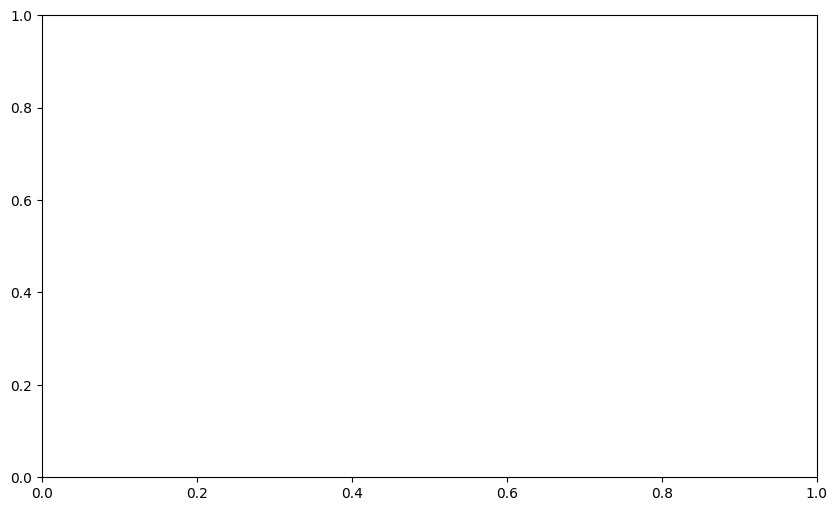

In [25]:
metrics_labels = ['Accuracy', 'Specificity', 'Sensitivity']
baseline_data = baseline_metrics_list
feresnet_data = feresnet_metrics_list

# Combine the data for each metric
data_to_plot = [
    [baseline_data[i], feresnet_data[i]]
    for i in range(len(metrics_labels))
]

# Create boxplots grouped by metric
fig, ax = plt.subplots(figsize=(10, 6))

for i, metric_data in enumerate(data_to_plot):
    positions = [i * 3 + 1, i * 3 + 2]  # Space out the groups
    ax.boxplot(
        metric_data,
        positions=positions,
        widths=0.6,
        patch_artist=True,
        labels=['Baseline', 'FeResNet'] if i == 0 else None,
    )

# Add labels and grid
ax.set_xticks([i * 3 + 1.5 for i in range(len(metrics_labels))])
ax.set_xticklabels(metrics_labels)
ax.set_title('Comparison of Metrics Between Baseline and FeResNet')
ax.set_ylabel('Metric Values')
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend(["Baseline", "FeResNet"], loc='upper left')
plt.tight_layout()
plt.show()


In [15]:
data = [cat_acc, np.nanmean(spec, axis=1), np.nanmean(sens, axis=1)]

# Create the box plot
plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=['Cat Acc', 'Spec', 'Sens'])
plt.title('Box Plot of Metrics')
plt.ylabel('Values')
plt.grid(True)

# Show the plot
plt.show()

NameError: name 'cat_acc' is not defined

In [33]:
data = np.array([cat_acc, np.nanmean(spec, axis=1), np.nanmean(sens, axis=1)])

NameError: name 'cat_acc' is not defined

In [14]:
data.shape

(3, 26)

In [15]:
np.mean(data, axis=1), np.std(data, axis=1)

(array([0.7674934 , 0.86386544, 0.60097499]),
 array([0.15491663, 0.10772861, 0.21968394]))

In [18]:
!ls ../../configs/

__init__.py  new_patient_ids.npy  test_patient_ids_2.npy  test_patient_ids.npy


In [26]:
from evaluation.eggim import *
def replace_landmark_name(landmark):
    new_landmark_name = {'ii': 'distal body',
                    'ix': 'distal lc',
                    'vi': 'proximal ant lc',
                    'vii': 'proximal ant gc/pw',
                    'viii': 'incisura r',
                    'x': 'upper body r',
                    'xii': 'upper body ant'}
    landmark_number = landmark.split('.')[0]
    return new_landmark_name[landmark_number]

dp = DatasetProcessor(target_dir)
df = dp.process()
df['landmark'] = df['landmark'].apply(replace_landmark_name)
patient_ids = np.load('../../configs/new_patient_ids.npy', allow_pickle=True)

togas_ids_boolean = np.array([x.startswith('PT') for x in df['patient_id'].values])
df_togas = df[togas_ids_boolean].reset_index(drop=True)
df_ipo = df[~togas_ids_boolean].reset_index(drop=True)


In [27]:
df = df_togas[['landmark', 'eggim_square']].value_counts()
df

landmark            eggim_square
distal lc           0               99
proximal ant gc/pw  0               86
distal body         0               79
upper body ant      0               71
proximal ant lc     0               64
incisura r          0               59
                    1               58
upper body r        0               51
proximal ant lc     2               48
proximal ant gc/pw  2               46
proximal ant lc     1               38
incisura r          2               37
distal lc           1               33
proximal ant gc/pw  1               28
distal lc           2               23
upper body ant      1               13
upper body r        1               10
                    2                9
distal body         1                8
upper body ant      2                3
distal body         2                3
Name: count, dtype: int64

In [28]:
def compute_eggim_patient(patient_df, target_variable):
    df = patient_df[['landmark', target_variable]].value_counts()

    # Assume first landmark/score pair is correct
    eggim_antrum_incisura = (
        df['proximal ant lc'].index[0] +
        df['proximal ant gc/pw'].index[0] +
        df['incisura r'].index[0]
    )

    # Compute eggim_body_1
    body_1_values = []
    if 'distal body' in df:
        body_1_values.append(df['distal body'].index[0])
    if 'upper body ant' in df:
        body_1_values.append(df['upper body ant'].index[0])

    if body_1_values:
        eggim_body_1 = sum(body_1_values) / len(body_1_values)

    # Compute eggim_body_2
    body_2_values = []
    if 'distal lc' in df:
        body_2_values.append(df['distal lc'].index[0])
    if 'upper body r' in df:
        body_2_values.append(df['upper body r'].index[0])

    if body_2_values:
        eggim_body_2 = sum(body_2_values) / len(body_2_values)

    return eggim_antrum_incisura + eggim_body_1 + eggim_body_2

eggim_scores = {}
patients_dfs = []
print("FE_RESNET")
for i, patient_id in enumerate(patient_ids):
    df_patient = df_togas[df_togas['patient_id'] == patient_id]
    df_patient['pred'] = y_feresnet_ordinals[i]
    patients_dfs.append(df_patient)
    try:
        eggim_square = compute_eggim_patient(df_patient,
                                          target_variable='eggim_square')
        eggim_global = compute_eggim_patient(df_patient,
                                      target_variable='eggim_global')
        eggim_pred = compute_eggim_patient(df_patient,
                                      target_variable='pred')
        eggim_scores[patient_ids[i]] = {'eggim_square': eggim_square, 'eggim_global': eggim_global,
                                        'eggim_pred': eggim_pred}
    except:
        print("bad ", patient_id)
eggim_df = pd.DataFrame(eggim_scores).T

FE_RESNET


/tmp/ipykernel_574896/340857014.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_patient['pred'] = y_feresnet_ordinals[i]
/tmp/ipykernel_574896/340857014.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_patient['pred'] = y_feresnet_ordinals[i]
/tmp/ipykernel_574896/340857014.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [29]:
patients_dfs = pd.concat(patients_dfs)
patients_dfs.to_csv('fe_scores.csv')
eggim_df.to_csv("fe_eggim_revised.csv")

In [30]:
from sklearn.metrics import confusion_matrix
# Function to calculate sensitivity and specificity
def calculate_eggim_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    accuracy = (tp + tn) / (tp + tn + fp + fn)  if (tp + tn + fp + fn) > 0 else 0.0
    return sensitivity, specificity, accuracy

cutoff = 5
y = np.array([1 if eggim >= cutoff else 0 for eggim in eggim_df['eggim_square'].values])
y_pred = np.array([1 if eggim >= cutoff else 0 for eggim in eggim_df['eggim_pred'].values])

print(np.sum(y != y_pred))

calculate_eggim_metrics(np.array([1 if eggim >= cutoff else 0 for eggim in eggim_df['eggim_square'].values]),
                                  np.array([1 if eggim >= cutoff else 0 for eggim in eggim_df['eggim_pred'].values]))

7


(0.6923076923076923, 0.9423076923076923, 0.8923076923076924)

In [31]:
eggim_scores = {}
patients_dfs = []
for i, patient_id in enumerate(patient_ids):
    df_patient = df_togas[df_togas['patient_id'] == patient_id]
    df_patient['pred'] = y_baseline_ordinals[i]
    patients_dfs.append(df_patient)
    eggim_square = compute_eggim_patient(df_patient,
                                          target_variable='eggim_square')
    eggim_global = compute_eggim_patient(df_patient,
                                  target_variable='eggim_global')
    eggim_pred = compute_eggim_patient(df_patient,
                                  target_variable='pred')
    eggim_scores[patient_ids[i]] = {'eggim_square': eggim_square, 'eggim_global': eggim_global,
                                    'eggim_pred': eggim_pred}
eggim_df = pd.DataFrame(eggim_scores).T

/tmp/ipykernel_574896/1310737740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_patient['pred'] = y_baseline_ordinals[i]
/tmp/ipykernel_574896/1310737740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_patient['pred'] = y_baseline_ordinals[i]
/tmp/ipykernel_574896/1310737740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [32]:
patients_dfs = pd.concat(patients_dfs)
patients_dfs.to_csv('baseline_scores.csv')
eggim_df.to_csv("fe_eggim_revised.csv")

In [33]:


y = np.array([1 if eggim >= cutoff else 0 for eggim in eggim_df['eggim_square'].values])
y_pred = np.array([1 if eggim >= cutoff else 0 for eggim in eggim_df['eggim_pred'].values])

print(np.sum(y != y_pred))

calculate_eggim_metrics(np.array([1 if eggim >= cutoff else 0 for eggim in eggim_df['eggim_square'].values]),
                                  np.array([1 if eggim >= cutoff else 0 for eggim in eggim_df['eggim_pred'].values]))

12


(1.0, 0.7692307692307693, 0.8153846153846154)

In [58]:
59 / 65

0.9076923076923077

In [51]:
y = np.array([1 if eggim >= cutoff else 0 for eggim in eggim_df['eggim_square'].values])
y_pred = np.array([1 if eggim >= cutoff else 0 for eggim in eggim_df['eggim_pred'].values])

np.sum(y != y_pred)

7

In [32]:
print(os.getcwd())

/home/miguelmartins/Projects/eggimazing/notebooks/multi_patient_wise


In [33]:
# minimum error of patch vs global labels
best_possible_eggim_mae = np.mean(np.abs(eggim_df.iloc[:, 1] -  eggim_df.iloc[:, 0]))

In [34]:
# error of patch predictions vs patch labels
patch_eggim_mae =  np.mean(np.abs(eggim_df.iloc[:, 0] -  eggim_df.iloc[:, 2]))

In [35]:
patch_global_eggim_mae = np.mean(np.abs(eggim_df.iloc[:, 1] -  eggim_df.iloc[:, 2]))

In [36]:
patch_eggim_mae

1.0153846153846153

In [37]:
# patch ground truth vs patch pred:
patch_eggim_mae

1.0153846153846153

In [38]:
# global ground truth vs patch pred
patch_global_eggim_mae

1.0153846153846153

In [39]:
# global ground truth vs patch pred "adjusted" with minimum error in square labels
patch_global_eggim_mae - best_possible_eggim_mae

0.9076923076923076